In [15]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from SwarmPackagePy import pso
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import roc_auc_score
from SwarmPackagePy import gsa

train_dir = "..\isec-ic\\dataset\\train"
validation_dir = "..\isec-ic\\dataset\\valid"
test_dir = "..\isec-ic\\dataset\\test"

current_dir = os.path.dirname(os.path.realpath(__file__ if '__file__' in locals() else os.getcwd()))
train_dir = os.path.join(current_dir, train_dir)
validation_dir = os.path.join(current_dir, validation_dir)
test_dir = os.path.join(current_dir, test_dir)

categories = ["bacterialspot", "healthy", "lateblight","leafmold", "mosaicvirus","yellowleafcurlvirus" ,"spidermite","septorialeafspot" ]

def load_images_from_folder(folder):
    images = []
    labels = []
    subfolders = os.listdir(folder) 
    for subfolder in subfolders:
        category = subfolder.split("_")[-1].lower()
        if category in categories:
            print("Loading images from category: " + category + " and subfolder: " + subfolder)
            subfolder_path = os.path.join(folder, subfolder)
            for filename in os.listdir(subfolder_path):
                img = Image.open(os.path.join(subfolder_path, filename))
                img = img.resize((64, 64)) 
                img = np.array(img) / 255.0 
                images.append(img)
                labels.append(categories.index(category))
        else:
            print("Category: " + category + " from subfolder " + subfolder + " is not in the list of categories.")
    return np.array(images), np.array(labels)

def create_cnn_model(num_neurons, learning_rate):
    input_shape = (64, 64, 3)
    num_classes = len(categories)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    # Aqui, o número de neurônios da única camada escondida é variável
    model.add(tf.keras.layers.Conv2D(num_neurons, kernel_size=(3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

def evaluate_model_GSA(solution):
    num_neurons, learning_rate = solution
    model = create_cnn_model(num_neurons, learning_rate)
    model.fit(x_train, y_train, epochs=5, batch_size=32, verbose=0)
    
    # Predições e cálculo do AUC
    y_pred = model.predict(x_validation)
    y_validation_categorical = to_categorical(y_validation, num_classes=len(categories))
    auc_score = roc_auc_score(y_validation_categorical, y_pred, multi_class='ovr')

    return 1 - auc_score  # Minimizar 1 - AUC

x_train, y_train = load_images_from_folder(train_dir)
x_validation, y_validation = load_images_from_folder(validation_dir)
x_test, y_test = load_images_from_folder(test_dir)


# Inicializar e executar GSA
num_agents = 3  # Número de agentes
max_iter = 10    # Número de iterações
dimension = 2    # Número de dimensões (neste caso, num_neurons e learning_rate)
lb = [10, 0.0001]   # Limites inferiores para num_neurons e learning_rate
ub = [100, 0.01]    # Limites superiores para num_neurons e learning_rate


# Configurações do GSA
print("Iniciando a otimização com GSA...")
gsa_instance = gsa(n=num_agents, function=evaluate_model_GSA, lb=lb, ub=ub, dimension=dimension, iteration=max_iter)
best_solution_gsa = gsa_instance.get_Gbest()

best_num_neurons_gsa, best_learning_rate_gsa = best_solution_gsa
print(f"Melhores parâmetros encontrados pelo GSA: \nNúmero de Neurônios: {best_num_neurons_gsa}, Learning Rate: {best_learning_rate_gsa}")

Loading images from category: spidermite and subfolder: Tomato__spidermite
Loading images from category: bacterialspot and subfolder: Tomato___Bacterialspot
Category: earlyblight from subfolder Tomato___Earlyblight is not in the list of categories.
Loading images from category: healthy and subfolder: Tomato___healthy
Loading images from category: lateblight and subfolder: Tomato___Lateblight
Loading images from category: leafmold and subfolder: Tomato___Leafmold
Loading images from category: septorialeafspot and subfolder: Tomato___Septorialeafspot
Category: targetspot from subfolder Tomato___Targetspot is not in the list of categories.
Loading images from category: mosaicvirus and subfolder: Tomato___Tomato_mosaicvirus
Loading images from category: yellowleafcurlvirus and subfolder: Tomato___Tomato_yellowleafcurlvirus
Loading images from category: bacterialspot and subfolder: Tomato___Bacterialspot
Category: earlyblight from subfolder Tomato___Earlyblight is not in the list of categor

Treinando o modelo com os melhores hiperparâmetros...
Epoch 1/10
375/375 [==============================] - 9s 24ms/step - loss: 1.4669 - accuracy: 0.4607 - val_loss: 0.9882 - val_accuracy: 0.6531
Epoch 2/10
375/375 [==============================] - 9s 24ms/step - loss: 0.8967 - accuracy: 0.6834 - val_loss: 0.8528 - val_accuracy: 0.7078
Epoch 3/10
375/375 [==============================] - 9s 24ms/step - loss: 0.7624 - accuracy: 0.7373 - val_loss: 0.7448 - val_accuracy: 0.7478
Epoch 4/10
375/375 [==============================] - 9s 24ms/step - loss: 0.6573 - accuracy: 0.7725 - val_loss: 0.7198 - val_accuracy: 0.7722
Epoch 5/10
375/375 [==============================] - 9s 24ms/step - loss: 0.5821 - accuracy: 0.7983 - val_loss: 1.0059 - val_accuracy: 0.7084
Epoch 6/10
375/375 [==============================] - 9s 24ms/step - loss: 0.5251 - accuracy: 0.8202 - val_loss: 0.6962 - val_accuracy: 0.7806
Epoch 7/10
375/375 [==============================] - 9s 24ms/step - loss: 0.5048 - accu

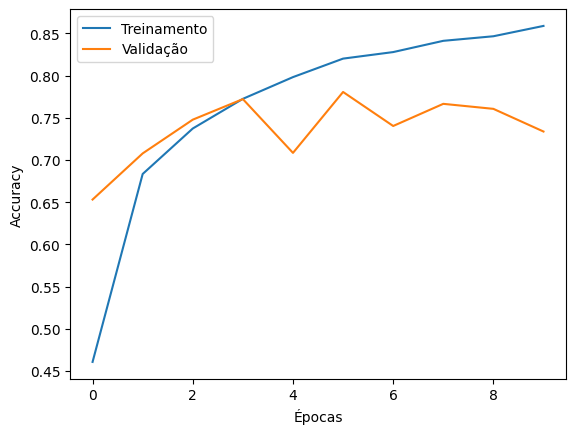

Avaliando o modelo no conjunto de teste...
Acurácia no Teste: 0.7350000143051147, Loss: 0.9511169195175171


In [29]:
import matplotlib.pyplot as plt

# Treinamento final e avaliação com os melhores hiperparâmetros
print("Treinando o modelo com os melhores hiperparâmetros...")
best_model = create_cnn_model(int(best_num_neurons_gsa), best_learning_rate_gsa)
best_model_history = best_model.fit(x_train, y_train, epochs=10, batch_size=32, verbose=1, validation_data=(x_validation, y_validation))

best_gsa_train_accuracy = best_model_history.history['accuracy'][-1]
best_gsa_validation_accuracy = best_model_history.history['val_accuracy'][-1]

print("Melhor Accuracy de Treinamento (CNN GSA):", best_gsa_train_accuracy)
print("Melhor Accuracy de Validação (CNN GSA):", best_gsa_validation_accuracy)

# Plotar as curvas de treino e validação
plt.plot(best_model_history.history['accuracy'], label='Treinamento')
plt.plot(best_model_history.history['val_accuracy'], label='Validação')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print("Avaliando o modelo no conjunto de teste...")
loss_test, test_accuracy = best_model.evaluate(x_test, y_test, verbose=0)

print(f"Acurácia no Teste: {test_accuracy}, Loss: {loss_test}")

25/25 [==============================] - 0s 7ms/step
AUC no Teste: 0.9557892857142857
25/25 [==============================] - 0s 7ms/step


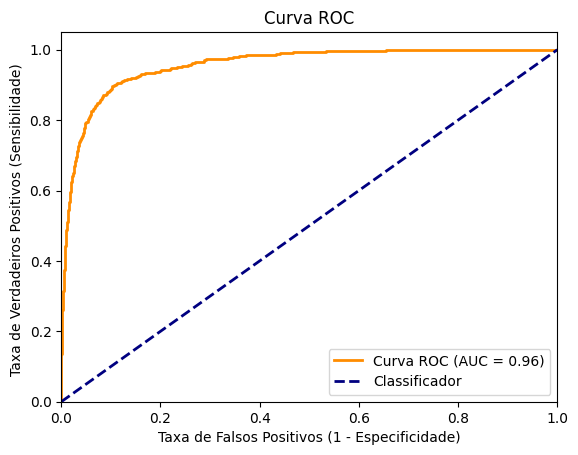

In [30]:
from sklearn.metrics import roc_curve, auc

y_pred_test = best_model.predict(x_test)
test_auc = roc_auc_score(to_categorical(y_test, num_classes=len(categories)), y_pred_test, multi_class='ovr')
print(f"AUC no Teste: {test_auc}")

# Previsões do modelo
y_pred = best_model.predict(x_test)

# Convertendo os rótulos de teste para o formato categórico
y_test_categorical = to_categorical(y_test, num_classes=len(categories))

# Calculando a taxa de verdadeiros e falsos positivos para cada limiar
fpr, tpr, thresholds = roc_curve(y_test_categorical.ravel(), y_pred.ravel())

# Calculando a área sob a curva (AUC)
roc_auc = auc(fpr, tpr)

# Gerando o gráfico
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Classificador')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (1 - Especificidade)')
plt.ylabel('Taxa de Verdadeiros Positivos (Sensibilidade) ')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

In [31]:
import os
import pandas as pd

resultados_gsa = pd.DataFrame(columns=['Tipo', 'Num_Agentes', 'Num_Iterações', 'Dimensão', 'Limite_Inferior', 'Limite_Superior', 'Num_Neurônios', 'Learning_Rate', 'Train_Accuracy', 'Validation_Accuracy', 'Test_Accuracy','Test_AUC'])
linha_nova = pd.DataFrame([{
    'Tipo': 'GSA',
    'Num_Agentes': num_agents,
    'Num_Iterações': max_iter,
    'Dimensão': dimension,
    'Limite_Inferior': lb,
    'Limite_Superior': ub,
    'Num_Neurônios': best_num_neurons_gsa,
    'Learning_Rate': best_learning_rate_gsa,
    'Train_Accuracy': best_gsa_train_accuracy,
    'Validation_Accuracy': best_gsa_validation_accuracy,
    'Test_Accuracy': test_accuracy,
    'Test_AUC': test_auc
}])

resultados_gsa = pd.concat([resultados_gsa, linha_nova], ignore_index=True)


caminho_csv = 'resultados_gsa.csv'
if os.path.exists(caminho_csv):
    # Se o arquivo existir, carregar e anexar os novos resultados
    resultados_existentes = pd.read_csv(caminho_csv)
    resultados_atualizados = pd.concat([resultados_existentes, resultados_gsa], ignore_index=True)
    resultados_atualizados.to_csv(caminho_csv, index=False)
    print("adding results to a csv that exists")
else:
    # Se o arquivo não existir, criar um novo
    resultados_gsa.to_csv(caminho_csv, index=False)
    print("created csv")

adding results to a csv that exists
